<a href="https://colab.research.google.com/github/manu675/analytics_cup_21/blob/main/AC_python_classifiers_latest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Business Analytics - Analytics Cup 21

**Status Quo (January 27):**   
XGB Classifier - balanced accuracy: 0.6835  
Logistic Regression - balanced accuracy: 0.5206  
Naive Bayes - balanced accuracy: 0.5297  

General background on imbalanced classification:  
https://towardsdatascience.com/guide-to-classification-on-imbalanced-datasets-d6653aa5fa23

# Importing Libraries

In [ ]:
# installing a library to learn from imbalanced data sets via the terminal
## ! sudo pip install imbalanced-learn 

In [23]:
# importing libaries:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, roc_curve, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from collections import Counter

from scipy.stats import loguniform, randint, uniform

import imblearn
print(imblearn.__version__)

from imblearn.over_sampling import RandomOverSampler
from sklearn.utils import class_weight


0.4.3


In [24]:
# hiding warnings
import warnings
warnings.filterwarnings('ignore')

## Reading in the data

In [37]:
## Way 2: uploading the local data to google colab
# importing local data to google colab:
from google.colab import files
uploaded = files.upload()


Saving train_physicians_df_22_F.csv to train_physicians_df_22_F.csv


In [38]:
## Way 2: uploading the local data to google colab
# importing local data to google colab:
from google.colab import files
uploaded = files.upload()


Saving test_physicians_df_22_F.csv to test_physicians_df_22_F.csv


In [41]:
train = pd.read_csv("train_physicians_df_22_F.csv", sep =";")

In [42]:
test = pd.read_csv("test_physicians_df_22_F.csv", sep =";")

In [43]:
train.head()

,Physician_ID,State,Primary_Specialty,Ownership_Indicator,total_payments,number_of_payments,top_nature,total_of_top_nature,range_count,range_total,top_company,pay_count,std,top_rpi,rpi_count,cash,services,stock,stock_opt,any_ownership,dividend,stock_or_other,top_fop,fop_count
0,1,FL,Obstetrics & Gynecology,0,952.93,47,Food and Beverage,842.44,8,170.41,550,18,6.498346,Covered,26,4.0,43.0,0.0,0.0,0.0,0.0,0.0,In-kind items and services,43
1,2,MD,Anesthesiology,0,120924.92,154,Compensation for services other than consultin...,45190.70,45,35030.52,601,13,478.199770,Covered,88,72.0,82.0,0.0,0.0,0.0,0.0,0.0,In-kind items and services,82
2,3,NY,Podiatric Medicine & Surgery Service Providers,0,3523.93,132,Food and Beverage,3523.93,12,462.42,340,15,35.449082,Yes,75,39.0,93.0,0.0,0.0,0.0,0.0,0.0,In-kind items and services,93
3,4,GA,Internal Medicine,0,26745.61,411,Compensation for services other than consultin...,18011.81,50,13247.09,18,32,129.869365,Yes,231,131.0,280.0,0.0,0.0,0.0,0.0,0.0,In-kind items and services,280
4,5,NM,Orthopaedic Surgery,0,25411.21,98,Education,8792.00,18,9079.72,442,13,1741.832451,Covered,41,16.0,82.0,0.0,0.0,0.0,0.0,0.0,In-kind items and services,82


In [44]:
test.head()

,Physician_ID,State,Primary_Specialty,total_payments,number_of_payments,top_nature,total_of_top_nature,range_count,range_total,top_company,pay_count,std,top_rpi,rpi_count,cash,services,stock,stock_opt,any_ownership,dividend,stock_or_other,top_fop,fop_count
0,14,FL,Pain Medicine,5775.53,539,Food and Beverage,5626.66,96,514.07,197,35,4.599791,Yes,360,56.0,483.0,0.0,0.0,0.0,0.0,0.0,In-kind items and services,483
1,18,NY,Internal Medicine,92123.24,584,Consulting Fee,39516.38,68,42697.24,2285,46,162.675507,Yes,417,100.0,484.0,0.0,0.0,0.0,0.0,0.0,In-kind items and services,484
2,42,NY,Obstetrics & Gynecology,3159.49,180,Food and Beverage,3066.04,16,256.09,190,27,3.431789,Yes,108,8.0,172.0,0.0,0.0,0.0,0.0,0.0,In-kind items and services,172
3,46,MI,NaN,1614.34,64,Food and Beverage,1614.34,15,547.14,897,17,20.521972,Yes,49,2.0,62.0,0.0,0.0,0.0,0.0,0.0,In-kind items and services,62
4,47,MD,Internal Medicine,6494.00,296,Food and Beverage,6444.00,96,1557.50,123,31,13.168132,Yes,253,21.0,275.0,0.0,0.0,0.0,0.0,0.0,In-kind items and services,275


In [47]:
train.shape

(5000, 24)

In [48]:
test.shape

(1000, 23)

In [49]:
train = train.set_index('Physician_ID')

In [51]:
train["Ownership_Indicator"].value_counts()

0    4700
1     300
Name: Ownership_Indicator, dtype: int64

In [52]:
# labels 
y_train = train["Ownership_Indicator"][0:4000]

y_test = train["Ownership_Indicator"][4001:5000]

print(y_train, y_test)

Physician_ID
1       0
2       0
3       0
4       0
5       0
       ..
4805    0
4806    0
4808    0
4809    0
4810    0
Name: Ownership_Indicator, Length: 4000, dtype: int64 Physician_ID
4814    0
4815    0
4816    0
4819    0
4820    0
       ..
5995    0
5996    0
5997    0
5998    0
6000    0
Name: Ownership_Indicator, Length: 999, dtype: int64


In [53]:
y_train.value_counts()

0    3757
1     243
Name: Ownership_Indicator, dtype: int64

In [54]:
y_test.value_counts()

0    942
1     57
Name: Ownership_Indicator, dtype: int64

In [55]:
train.columns

Index(['State', 'Primary_Specialty', 'Ownership_Indicator', 'total_payments',
       'number_of_payments', 'top_nature', 'total_of_top_nature',
       'range_count', 'range_total', 'top_company', 'pay_count', 'std',
       'top_rpi', 'rpi_count', 'cash', 'services', 'stock', 'stock_opt',
       'any_ownership', 'dividend', 'stock_or_other', 'top_fop', 'fop_count'],
      dtype='object')

In [56]:
# features (manually)
X_train = train[['Primary_Specialty', 'Ownership_Indicator', 'total_payments',
       'number_of_payments', 'top_nature', 'total_of_top_nature',
       'range_count', 'range_total', 'top_company', 'pay_count', 'std',
       'top_rpi', 'rpi_count', 'cash', 'services', 'stock', 'stock_opt',
       'any_ownership', 'dividend', 'stock_or_other', 'top_fop', 'fop_count']][0:4000]

X_test = train[['Primary_Specialty', 'Ownership_Indicator', 'total_payments',
       'number_of_payments', 'top_nature', 'total_of_top_nature',
       'range_count', 'range_total', 'top_company', 'pay_count', 'std',
       'top_rpi', 'rpi_count', 'cash', 'services', 'stock', 'stock_opt',
       'any_ownership', 'dividend', 'stock_or_other', 'top_fop', 'fop_count']][4001:5000]

## Full data (3 merged dataframes)

In [ ]:
# this allows for accessing files stored in your google drive using the path "/gdrive/My Drive/"
# mounting google drive locally:

##from google.colab import drive
##drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
##df = pd.read_csv("/gdrive/My Drive/full_df.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6,16,17,43) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Preprocessing

In [ ]:
df.head()

,Unnamed: 0,Physician_ID,set,First_Name,Middle_Name,Last_Name,Name_Suffix,City,State,Zipcode,Country.x,Province,Primary_Specialty,License_State_1,License_State_2,License_State_3,License_State_4,License_State_5,Company_ID,Record_ID,Total_Amount_of_Payment_USDollars,Date,Number_of_Payments,Form_of_Payment_or_Transfer_of_Value,Nature_of_Payment_or_Transfer_of_Value,City_of_Travel,State_of_Travel,Country_of_Travel,Ownership_Indicator,Third_Party_Recipient,Charity,Third_Party_Covered,Contextual_Information,Related_Product_Indicator,Product_Code_1,Product_Code_2,Product_Code_3,Product_Type_1,Product_Type_2,Product_Type_3,Product_Name_1,Product_Name_2,Product_Name_3,Product_Category_1,Product_Category_2,Product_Category_3,Company_name,Company_state,Country.y
0,1,1,train,LEIGH,B,HOPPE,NaN,FORT PIERCE,FL,34950,UNITED STATES,NaN,Allopathic & Osteopathic Physicians|Obstetrics...,FL,NaN,NaN,NaN,NaN,69,236420.0,15.13,09/11/2014,1,In-kind items and services,Food and Beverage,NaN,NaN,NaN,No,No Third Party Payment,NaN,NaN,NaN,Covered,NaN,NaN,NaN,Drug or Biological,Drug or Biological,NaN,Myrbetriq,Vesicare,NaN,NaN,NaN,NaN,Astellas Pharma US Inc,IL,United States
1,2,1,train,LEIGH,B,HOPPE,NaN,FORT PIERCE,FL,34950,UNITED STATES,NaN,Allopathic & Osteopathic Physicians|Obstetrics...,FL,NaN,NaN,NaN,NaN,450,22992.0,11.77,09/12/2013,1,In-kind items and services,Food and Beverage,NaN,NaN,NaN,No,No Third Party Payment,NaN,NaN,NaN,Covered,5963058000,NaN,NaN,Drug or Biological,NaN,NaN,Osphena,NaN,NaN,NaN,NaN,NaN,Shionogi Inc,NJ,United States
2,3,1,train,LEIGH,B,HOPPE,NaN,FORT PIERCE,FL,34950,UNITED STATES,NaN,Allopathic & Osteopathic Physicians|Obstetrics...,FL,NaN,NaN,NaN,NaN,550,1278340.0,20.78,05/10/2019,1,In-kind items and services,Food and Beverage,NaN,NaN,NaN,No,No Third Party Payment,No,NaN,NaN,Yes,NaN,NaN,NaN,Device,NaN,NaN,HARMONIC Product Family,NaN,NaN,NaN,NaN,NaN,"Medical Device Business Services, Inc.",IN,United States
3,4,1,train,LEIGH,B,HOPPE,NaN,FORT PIERCE,FL,34950,UNITED STATES,NaN,Allopathic & Osteopathic Physicians|Obstetrics...,FL,NaN,NaN,NaN,NaN,613,365090.0,23.74,04/09/2015,1,In-kind items and services,Food and Beverage,NaN,NaN,NaN,No,No Third Party Payment,NaN,NaN,NaN,Covered,NaN,NaN,NaN,Device or Medical Supply,NaN,NaN,THINPREP,NaN,NaN,NaN,NaN,NaN,HOLOGIC INC,MA,United States
4,5,1,train,LEIGH,B,HOPPE,NaN,FORT PIERCE,FL,34950,UNITED STATES,NaN,Allopathic & Osteopathic Physicians|Obstetrics...,FL,NaN,NaN,NaN,NaN,550,1278614.0,20.78,05/10/2019,1,In-kind items and services,Food and Beverage,NaN,NaN,NaN,No,No Third Party Payment,No,NaN,NaN,Yes,NaN,NaN,NaN,Device,NaN,NaN,HARMONIC Product Family,NaN,NaN,NaN,NaN,NaN,"Medical Device Business Services, Inc.",IN,United States


In [ ]:
df.columns

Index(['Unnamed: 0', 'Physician_ID', 'set', 'First_Name', 'Middle_Name',
       'Last_Name', 'Name_Suffix', 'City', 'State', 'Zipcode', 'Country.x',
       'Province', 'Primary_Specialty', 'License_State_1', 'License_State_2',
       'License_State_3', 'License_State_4', 'License_State_5', 'Company_ID',
       'Record_ID', 'Total_Amount_of_Payment_USDollars', 'Date',
       'Number_of_Payments', 'Form_of_Payment_or_Transfer_of_Value',
       'Nature_of_Payment_or_Transfer_of_Value', 'City_of_Travel',
       'State_of_Travel', 'Country_of_Travel', 'Ownership_Indicator',
       'Third_Party_Recipient', 'Charity', 'Third_Party_Covered',
       'Contextual_Information', 'Related_Product_Indicator', 'Product_Code_1',
       'Product_Code_2', 'Product_Code_3', 'Product_Type_1', 'Product_Type_2',
       'Product_Type_3', 'Product_Name_1', 'Product_Name_2', 'Product_Name_3',
       'Product_Category_1', 'Product_Category_2', 'Product_Category_3',
       'Company_name', 'Company_state', 'Countr

In [ ]:
# dimensionality of the df
df.shape

(1402250, 49)

In [ ]:
# pairwise correlations of the columns
df.corr()

,Unnamed: 0,Physician_ID,Province,Company_ID,Record_ID,Total_Amount_of_Payment_USDollars,Number_of_Payments,Product_Category_2,Product_Category_3
Unnamed: 0,1.000000,0.999901,NaN,-0.007077,-0.004893,0.000370,-0.001545,NaN,NaN
Physician_ID,0.999901,1.000000,NaN,-0.007202,-0.004926,0.000351,-0.001563,NaN,NaN
Province,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Company_ID,-0.007077,-0.007202,NaN,1.000000,0.141562,0.005695,-0.007207,NaN,NaN
Record_ID,-0.004893,-0.004926,NaN,0.141562,1.000000,0.000280,-0.007403,NaN,NaN
Total_Amount_of_Payment_USDollars,0.000370,0.000351,NaN,0.005695,0.000280,1.000000,0.002332,NaN,NaN
Number_of_Payments,-0.001545,-0.001563,NaN,-0.007207,-0.007403,0.002332,1.000000,NaN,NaN
Product_Category_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Product_Category_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Ordinal/One-hot Encoding 

 
Link: https://machinelearningmastery.com/one-hot-encoding-for-categorical-data/

Machine learning models require all input and output variables to be numeric.

This means that if your data contains categorical data, you must encode it to numbers before you can fit and evaluate a model.  

Types of data:    
**Numerical data**. Variable or features that is only composed of numbers, such as integers or floating-point values  
**Nominal/Categorical Variable**. Variable comprises a finite set of discrete values with no relationship between values.  
**Ordinal Variable**. Variable comprises a finite set of discrete values with a ranked ordering between values.

A numerical variable can be converted to an ordinal variable by dividing the range of the numerical variable into bins and assigning values to each bin. For example, a numerical variable between 1 and 10 can be divided into an ordinal variable with 5 labels with an ordinal relationship: 1-2, 3-4, 5-6, 7-8, 9-10. This is called **discretization**.


The following variants exist:
* One-hot encoding (each category value is converted into a new column and assigned a 1 or 0 (notation for true/false) value to the column)
* Ordinal encoding (=Integer Encoding) (each unique category value is assigned an integer value For example, “red” is 1, “green” is 2, and “blue” is 3)
* Label encoding (This approach is very simple and it involves converting each value in a column to a number)






**However, some algorithms can work with categorical data directly.**

For example, a decision tree can be learned directly from categorical data with no data transform required (this depends on the specific implementation).

In [161]:
train.head()

,State,Primary_Specialty,Ownership_Indicator,total_payments,number_of_payments,top_nature,total_of_top_nature,range_count,range_total,top_company,pay_count,std,top_rpi,rpi_count,cash,services,stock,stock_opt,any_ownership,dividend,stock_or_other,top_fop,fop_count
Physician_ID,,,,,,,,,,,,,,,,,,,,,,,
1,FL,Obstetrics & Gynecology,0,952.93,47,Food and Beverage,842.44,8,170.41,550,18,6.498346,Covered,26,4.0,43.0,0.0,0.0,0.0,0.0,0.0,In-kind items and services,43
2,MD,Anesthesiology,0,120924.92,154,Compensation for services other than consultin...,45190.70,45,35030.52,601,13,478.199770,Covered,88,72.0,82.0,0.0,0.0,0.0,0.0,0.0,In-kind items and services,82
3,NY,Podiatric Medicine & Surgery Service Providers,0,3523.93,132,Food and Beverage,3523.93,12,462.42,340,15,35.449082,Yes,75,39.0,93.0,0.0,0.0,0.0,0.0,0.0,In-kind items and services,93
4,GA,Internal Medicine,0,26745.61,411,Compensation for services other than consultin...,18011.81,50,13247.09,18,32,129.869365,Yes,231,131.0,280.0,0.0,0.0,0.0,0.0,0.0,In-kind items and services,280
5,NM,Orthopaedic Surgery,0,25411.21,98,Education,8792.00,18,9079.72,442,13,1741.832451,Covered,41,16.0,82.0,0.0,0.0,0.0,0.0,0.0,In-kind items and services,82


In [162]:
train.shape

(5000, 23)

In [163]:
# checking the column data types to figures out which attributes are categorical (object) and which ones numerical (int)
train.dtypes

State                   object
Primary_Specialty       object
Ownership_Indicator      int64
total_payments         float64
number_of_payments       int64
top_nature              object
total_of_top_nature    float64
range_count              int64
range_total            float64
top_company              int64
pay_count                int64
std                    float64
top_rpi                 object
rpi_count                int64
cash                   float64
services               float64
stock                  float64
stock_opt              float64
any_ownership          float64
dividend               float64
stock_or_other         float64
top_fop                 object
fop_count                int64
dtype: object

In [164]:
cat_feature_mask = train.dtypes == object # boolean test (mask) of whether the col is of "object type" or not
cat_feature_mask

State                   True
Primary_Specialty       True
Ownership_Indicator    False
total_payments         False
number_of_payments     False
top_nature              True
total_of_top_nature    False
range_count            False
range_total            False
top_company            False
pay_count              False
std                    False
top_rpi                 True
rpi_count              False
cash                   False
services               False
stock                  False
stock_opt              False
any_ownership          False
dividend               False
stock_or_other         False
top_fop                 True
fop_count              False
dtype: bool

In [165]:
# filter categorical columns using the mask and turn it into a list
cat_list = train.columns[cat_feature_mask].to_list()

cat_list

['State', 'Primary_Specialty', 'top_nature', 'top_rpi', 'top_fop']

In [166]:
# removing a list element
cat_list.remove("State")

cat_list

['Primary_Specialty', 'top_nature', 'top_rpi', 'top_fop']

In [167]:
train["Primary_Specialty"].unique()

array(['Obstetrics & Gynecology', 'Anesthesiology',
       'Podiatric Medicine & Surgery Service Providers',
       'Internal Medicine', 'Orthopaedic Surgery', 'Dental Providers',
       'Pediatrics', 'Surgery', 'Eye and Vision Services Providers',
       'Psychiatry & Neurology', 'Plastic Surgery',
       'Neurological Surgery', 'Dermatology', 'Emergency Medicine',
       'Ophthalmology', 'Family Medicine', 'Radiology', 'Otolaryngology',
       'Physical Medicine & Rehabilitation', 'Urology',
       'Preventive Medicine', 'Allergy & Immunology',
       'Thoracic Surgery (Cardiothoracic Vascular Surgery)',
       'Pain Medicine', 'Hospitalist', 'Colon & Rectal Surgery',
       'General Practice', 'Pathology', 'Oral & Maxillofacial Surgery',
       'Neuromusculoskeletal Medicine, Sports Medicine',
       'Chiropractic Providers', 'Nuclear Medicine',
       'Neuromusculoskeletal Medicine & OMM', 'Medical Genetics'],
      dtype=object)

In [168]:
train["Primary_Specialty"].unique().shape

(34,)

In [169]:
train["top_nature"].unique()

array(['Food and Beverage',
       'Compensation for services other than consulting, including serving as faculty or as a speaker at a venue other than a continuing education program',
       'Education', 'Consulting Fee', 'Travel and Lodging', 'Gift',
       'Honoraria',
       'Compensation for serving as faculty or as a speaker for a non-accredited and noncertified continuing education program',
       'Current or prospective ownership or investment interest', 'Grant',
       'Royalty or License',
       'Compensation for serving as faculty or as a speaker for an accredited or certified continuing education program',
       'Charitable Contribution'], dtype=object)

In [170]:
train["top_nature"].unique().shape

(13,)

removing NaN values

In [171]:
# detecting and counting missing values (NaNs)
train.isnull().sum()

State                  1
Primary_Specialty      0
Ownership_Indicator    0
total_payments         0
number_of_payments     0
top_nature             0
total_of_top_nature    0
range_count            0
range_total            0
top_company            0
pay_count              0
std                    0
top_rpi                0
rpi_count              0
cash                   0
services               0
stock                  0
stock_opt              0
any_ownership          0
dividend               0
stock_or_other         0
top_fop                0
fop_count              0
dtype: int64

In [172]:
# mode class = Internal Medicine 
train["Primary_Specialty"].value_counts()

Internal Medicine                                     1638
Family Medicine                                        548
Obstetrics & Gynecology                                301
Psychiatry & Neurology                                 284
Eye and Vision Services Providers                      267
Dental Providers                                       251
Orthopaedic Surgery                                    248
Pediatrics                                             214
Surgery                                                190
Ophthalmology                                          162
Urology                                                132
Podiatric Medicine & Surgery Service Providers         114
Dermatology                                            103
Anesthesiology                                          72
Radiology                                               69
Otolaryngology                                          65
Allergy & Immunology                                    

In [173]:
# imputation of  NaN values with the most frequent class
train["Primary_Specialty"] = train["Primary_Specialty"].replace(np.nan, 'Internal Medicine', regex=True)

In [174]:
train["std"].describe()

count     5000.000000
mean       202.151413
std       1626.166022
min          1.274216
25%         14.415188
50%         31.832498
75%         81.307494
max      59827.336312
Name: std, dtype: float64

In [175]:
train["std"].median()

31.832497573581524

In [176]:
# imputation of  NaN values with the median value of the feature
train["std"] = train["std"].replace(np.nan, train["std"].median(), regex=True)

In [177]:
train.isnull().sum() # check

State                  1
Primary_Specialty      0
Ownership_Indicator    0
total_payments         0
number_of_payments     0
top_nature             0
total_of_top_nature    0
range_count            0
range_total            0
top_company            0
pay_count              0
std                    0
top_rpi                0
rpi_count              0
cash                   0
services               0
stock                  0
stock_opt              0
any_ownership          0
dividend               0
stock_or_other         0
top_fop                0
fop_count              0
dtype: int64

In [178]:
# transforming the categorical columns to numerical values using a ONE HOT ENCODER

# The encoder has a method called fit_transform(). It takes a dataframe as an input, and will spit out the 
# transformed dataframe. Remember to specify the columns you need to transform (you have a list for this). 


# define one hot encoding
onehot_encoder = OneHotEncoder(sparse=False)

# one hot encoding primary specialty
##ps_enc = onehot_encoder.fit_transform(train["Primary_Specialty"])

data = train[cat_list]

# transform data
result_oh = pd.DataFrame(onehot_encoder.fit_transform(data))
print(result_oh)


       0    1    2    3    4    5    6   ...   48   49   50   51   52   53   54
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  1.0  0.0  0.0  0.0  0.0  0.0  1.0
1     0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...  1.0  0.0  0.0  0.0  0.0  0.0  1.0
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  1.0  0.0  1.0
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  1.0  0.0  1.0
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  1.0  0.0  0.0  0.0  0.0  0.0  1.0
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
4995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  1.0  0.0  1.0
4996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  1.0  0.0  0.0  0.0  0.0  0.0  1.0
4997  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  1.0  0.0  1.0
4998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  1.0  0.0  1.0
4999  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  1.0  1.0  0.0

[5000 rows x 55 columns]


In [179]:
# colnames of encoded features
onehot_encoder.get_feature_names()

array(['x0_Allergy & Immunology', 'x0_Anesthesiology',
       'x0_Chiropractic Providers', 'x0_Colon & Rectal Surgery',
       'x0_Dental Providers', 'x0_Dermatology', 'x0_Emergency Medicine',
       'x0_Eye and Vision Services Providers', 'x0_Family Medicine',
       'x0_General Practice', 'x0_Hospitalist', 'x0_Internal Medicine',
       'x0_Medical Genetics', 'x0_Neurological Surgery',
       'x0_Neuromusculoskeletal Medicine & OMM',
       'x0_Neuromusculoskeletal Medicine, Sports Medicine',
       'x0_Nuclear Medicine', 'x0_Obstetrics & Gynecology',
       'x0_Ophthalmology', 'x0_Oral & Maxillofacial Surgery',
       'x0_Orthopaedic Surgery', 'x0_Otolaryngology', 'x0_Pain Medicine',
       'x0_Pathology', 'x0_Pediatrics',
       'x0_Physical Medicine & Rehabilitation', 'x0_Plastic Surgery',
       'x0_Podiatric Medicine & Surgery Service Providers',
       'x0_Preventive Medicine', 'x0_Psychiatry & Neurology',
       'x0_Radiology', 'x0_Surgery',
       'x0_Thoracic Surgery (Cardio

In [180]:
# renaming the encoded columns 
result_oh.columns = onehot_encoder.get_feature_names() 

result_oh

,x0_Allergy & Immunology,x0_Anesthesiology,x0_Chiropractic Providers,x0_Colon & Rectal Surgery,x0_Dental Providers,x0_Dermatology,x0_Emergency Medicine,x0_Eye and Vision Services Providers,x0_Family Medicine,x0_General Practice,x0_Hospitalist,x0_Internal Medicine,x0_Medical Genetics,x0_Neurological Surgery,x0_Neuromusculoskeletal Medicine & OMM,"x0_Neuromusculoskeletal Medicine, Sports Medicine",x0_Nuclear Medicine,x0_Obstetrics & Gynecology,x0_Ophthalmology,x0_Oral & Maxillofacial Surgery,x0_Orthopaedic Surgery,x0_Otolaryngology,x0_Pain Medicine,x0_Pathology,x0_Pediatrics,x0_Physical Medicine & Rehabilitation,x0_Plastic Surgery,x0_Podiatric Medicine & Surgery Service Providers,x0_Preventive Medicine,x0_Psychiatry & Neurology,x0_Radiology,x0_Surgery,x0_Thoracic Surgery (Cardiothoracic Vascular Surgery),x0_Urology,x1_Charitable Contribution,"x1_Compensation for services other than consulting, including serving as faculty or as a speaker at a venue other than a continuing education program",x1_Compensation for serving as faculty or as a speaker for a non-accredited and noncertified continuing education program,x1_Compensation for serving as faculty or as a speaker for an accredited or certified continuing education program,x1_Consulting Fee,x1_Current or prospective ownership or investment interest,x1_Education,x1_Food and Beverage,x1_Gift,x1_Grant,x1_Honoraria,x1_Royalty or License,x1_Travel and Lodging,x2_Combination,x2_Covered,x2_No,x2_Non-Covered,x2_None,x2_Yes,x3_Cash or cash equivalent,x3_In-kind items and services
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [ ]:
# transforming the categorical columns to numerical values using an ORDINAL ENCODER

# The encoder has a method called fit_transform(). It takes a dataframe as an input, and will spit out the 
# transformed dataframe. Remember to specify the columns you need to transform (you have a list for this). 


# define ordinal encoding
##ordinal_encoder = OrdinalEncoder()

# one hot encoding primary specialty
##ps_enc = onehot_encoder.fit_transform(train["Primary_Specialty"])

#data = train[cat_list]

# transform data
##result = pd.DataFrame(ordinal_encoder.fit_transform(data))
##print(result)



Adding the encoded columns to the training and test data

In [181]:
# merging the two dfs
train_final = pd.concat([train.reset_index(drop=True), result_oh], axis=1)

train_final

,State,Primary_Specialty,Ownership_Indicator,total_payments,number_of_payments,top_nature,total_of_top_nature,range_count,range_total,top_company,pay_count,std,top_rpi,rpi_count,cash,services,stock,stock_opt,any_ownership,dividend,stock_or_other,top_fop,fop_count,x0_Allergy & Immunology,x0_Anesthesiology,x0_Chiropractic Providers,x0_Colon & Rectal Surgery,x0_Dental Providers,x0_Dermatology,x0_Emergency Medicine,x0_Eye and Vision Services Providers,x0_Family Medicine,x0_General Practice,x0_Hospitalist,x0_Internal Medicine,x0_Medical Genetics,x0_Neurological Surgery,x0_Neuromusculoskeletal Medicine & OMM,"x0_Neuromusculoskeletal Medicine, Sports Medicine",x0_Nuclear Medicine,x0_Obstetrics & Gynecology,x0_Ophthalmology,x0_Oral & Maxillofacial Surgery,x0_Orthopaedic Surgery,x0_Otolaryngology,x0_Pain Medicine,x0_Pathology,x0_Pediatrics,x0_Physical Medicine & Rehabilitation,x0_Plastic Surgery,x0_Podiatric Medicine & Surgery Service Providers,x0_Preventive Medicine,x0_Psychiatry & Neurology,x0_Radiology,x0_Surgery,x0_Thoracic Surgery (Cardiothoracic Vascular Surgery),x0_Urology,x1_Charitable Contribution,"x1_Compensation for services other than consulting, including serving as faculty or as a speaker at a venue other than a continuing education program",x1_Compensation for serving as faculty or as a speaker for a non-accredited and noncertified continuing education program,x1_Compensation for serving as faculty or as a speaker for an accredited or certified continuing education program,x1_Consulting Fee,x1_Current or prospective ownership or investment interest,x1_Education,x1_Food and Beverage,x1_Gift,x1_Grant,x1_Honoraria,x1_Royalty or License,x1_Travel and Lodging,x2_Combination,x2_Covered,x2_No,x2_Non-Covered,x2_None,x2_Yes,x3_Cash or cash equivalent,x3_In-kind items and services
0,FL,Obstetrics & Gynecology,0,952.93,47,Food and Beverage,842.44,8,170.41,550,18,6.498346,Covered,26,4.0,43.0,0.0,0.0,0.0,0.0,0.0,In-kind items and services,43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,MD,Anesthesiology,0,120924.92,154,Compensation for services other than consultin...,45190.70,45,35030.52,601,13,478.199770,Covered,88,72.0,82.0,0.0,0.0,0.0,0.0,0.0,In-kind items and services,82,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,NY,Podiatric Medicine & Surgery Service Providers,0,3523.93,132,Food and Beverage,3523.93,12,462.42,340,15,35.449082,Yes,75,39.0,93.0,0.0,0.0,0.0,0.0,0.0,In-kind items and services,93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,GA,Internal Medicine,0,26745.61,411,Compensation for services other than consultin...,18011.81,50,13247.09,18,32,129.869365,Yes,231,131.0,280.0,0.0,0.0,0.0,0.0,0.0,In-kind items and services,280,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,NM,Orthopaedic Surgery,0,25411.21,98,Education,8792.00,18,9079.72,442,13,1741.832451,Covered,41,16.0,82.0,0.0,0.0,0.0,0.0,0.0,In-kind items and services,82,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [182]:
# dropping the categorical features that have been encoded
train_final = train_final.drop(["Primary_Specialty","top_nature","top_rpi", "top_fop", "State"], axis=1)



In [183]:
train_final.head()

,Ownership_Indicator,total_payments,number_of_payments,total_of_top_nature,range_count,range_total,top_company,pay_count,std,rpi_count,cash,services,stock,stock_opt,any_ownership,dividend,stock_or_other,fop_count,x0_Allergy & Immunology,x0_Anesthesiology,x0_Chiropractic Providers,x0_Colon & Rectal Surgery,x0_Dental Providers,x0_Dermatology,x0_Emergency Medicine,x0_Eye and Vision Services Providers,x0_Family Medicine,x0_General Practice,x0_Hospitalist,x0_Internal Medicine,x0_Medical Genetics,x0_Neurological Surgery,x0_Neuromusculoskeletal Medicine & OMM,"x0_Neuromusculoskeletal Medicine, Sports Medicine",x0_Nuclear Medicine,x0_Obstetrics & Gynecology,x0_Ophthalmology,x0_Oral & Maxillofacial Surgery,x0_Orthopaedic Surgery,x0_Otolaryngology,x0_Pain Medicine,x0_Pathology,x0_Pediatrics,x0_Physical Medicine & Rehabilitation,x0_Plastic Surgery,x0_Podiatric Medicine & Surgery Service Providers,x0_Preventive Medicine,x0_Psychiatry & Neurology,x0_Radiology,x0_Surgery,x0_Thoracic Surgery (Cardiothoracic Vascular Surgery),x0_Urology,x1_Charitable Contribution,"x1_Compensation for services other than consulting, including serving as faculty or as a speaker at a venue other than a continuing education program",x1_Compensation for serving as faculty or as a speaker for a non-accredited and noncertified continuing education program,x1_Compensation for serving as faculty or as a speaker for an accredited or certified continuing education program,x1_Consulting Fee,x1_Current or prospective ownership or investment interest,x1_Education,x1_Food and Beverage,x1_Gift,x1_Grant,x1_Honoraria,x1_Royalty or License,x1_Travel and Lodging,x2_Combination,x2_Covered,x2_No,x2_Non-Covered,x2_None,x2_Yes,x3_Cash or cash equivalent,x3_In-kind items and services
0,0,952.93,47,842.44,8,170.41,550,18,6.498346,26,4.0,43.0,0.0,0.0,0.0,0.0,0.0,43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,120924.92,154,45190.70,45,35030.52,601,13,478.199770,88,72.0,82.0,0.0,0.0,0.0,0.0,0.0,82,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0,3523.93,132,3523.93,12,462.42,340,15,35.449082,75,39.0,93.0,0.0,0.0,0.0,0.0,0.0,93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0,26745.61,411,18011.81,50,13247.09,18,32,129.869365,231,131.0,280.0,0.0,0.0,0.0,0.0,0.0,280,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0,25411.21,98,8792.00,18,9079.72,442,13,1741.832451,41,16.0,82.0,0.0,0.0,0.0,0.0,0.0,82,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


train test split

In [184]:
# labels 
y_train = train_final["Ownership_Indicator"][0:4000]

y_test = train_final["Ownership_Indicator"][4001:5000]

print(y_train, y_test)

0       0
1       0
2       0
3       0
4       0
       ..
3995    0
3996    0
3997    0
3998    0
3999    0
Name: Ownership_Indicator, Length: 4000, dtype: int64 4001    0
4002    0
4003    0
4004    0
4005    0
       ..
4995    0
4996    0
4997    0
4998    0
4999    0
Name: Ownership_Indicator, Length: 999, dtype: int64


In [185]:
# features (manually)
X_train = train_final.drop(["Ownership_Indicator"], axis=1)[0:4000]

X_test = train_final.drop(["Ownership_Indicator"], axis=1)[4001:5000]
print(X_train, X_test)

      total_payments  ...  x3_In-kind items and services
0             952.93  ...                            1.0
1          120924.92  ...                            1.0
2            3523.93  ...                            1.0
3           26745.61  ...                            1.0
4           25411.21  ...                            1.0
...              ...  ...                            ...
3995        11664.99  ...                            1.0
3996         3840.33  ...                            1.0
3997         4477.70  ...                            1.0
3998        13395.22  ...                            1.0
3999         5800.27  ...                            1.0

[4000 rows x 72 columns]       total_payments  ...  x3_In-kind items and services
4001         9125.41  ...                            1.0
4002        13388.59  ...                            1.0
4003         1249.61  ...                            1.0
4004       173035.27  ...                            1.0
4005 

encoding test set

In [108]:
test.head()

,Physician_ID,State,Primary_Specialty,total_payments,number_of_payments,top_nature,total_of_top_nature,range_count,range_total,top_company,pay_count,std,top_rpi,rpi_count,cash,services,stock,stock_opt,any_ownership,dividend,stock_or_other,top_fop,fop_count
0,14,FL,Pain Medicine,5775.53,539,Food and Beverage,5626.66,96,514.07,197,35,4.599791,Yes,360,56.0,483.0,0.0,0.0,0.0,0.0,0.0,In-kind items and services,483
1,18,NY,Internal Medicine,92123.24,584,Consulting Fee,39516.38,68,42697.24,2285,46,162.675507,Yes,417,100.0,484.0,0.0,0.0,0.0,0.0,0.0,In-kind items and services,484
2,42,NY,Obstetrics & Gynecology,3159.49,180,Food and Beverage,3066.04,16,256.09,190,27,3.431789,Yes,108,8.0,172.0,0.0,0.0,0.0,0.0,0.0,In-kind items and services,172
3,46,MI,NaN,1614.34,64,Food and Beverage,1614.34,15,547.14,897,17,20.521972,Yes,49,2.0,62.0,0.0,0.0,0.0,0.0,0.0,In-kind items and services,62
4,47,MD,Internal Medicine,6494.00,296,Food and Beverage,6444.00,96,1557.50,123,31,13.168132,Yes,253,21.0,275.0,0.0,0.0,0.0,0.0,0.0,In-kind items and services,275


In [109]:
cat_feature_mask_ts = test.dtypes == object # boolean test (mask) of whether the col is of "object type" or not
cat_feature_mask_ts

Physician_ID           False
State                   True
Primary_Specialty       True
total_payments         False
number_of_payments     False
top_nature              True
total_of_top_nature    False
range_count            False
range_total            False
top_company            False
pay_count              False
std                    False
top_rpi                 True
rpi_count              False
cash                   False
services               False
stock                  False
stock_opt              False
any_ownership          False
dividend               False
stock_or_other         False
top_fop                 True
fop_count              False
dtype: bool

In [110]:
# filter categorical columns using the mask and turn it into a list
cat_list_ts = test.columns[cat_feature_mask_ts].to_list()

cat_list_ts

['State', 'Primary_Specialty', 'top_nature', 'top_rpi', 'top_fop']

In [111]:
cat_list_ts.remove("State")


In [112]:
test[cat_list_ts]

,Primary_Specialty,top_nature,top_rpi,top_fop
0,Pain Medicine,Food and Beverage,Yes,In-kind items and services
1,Internal Medicine,Consulting Fee,Yes,In-kind items and services
2,Obstetrics & Gynecology,Food and Beverage,Yes,In-kind items and services
3,NaN,Food and Beverage,Yes,In-kind items and services
4,Internal Medicine,Food and Beverage,Yes,In-kind items and services
...,...,...,...,...
995,Internal Medicine,Compensation for services other than consultin...,Covered,In-kind items and services
996,Urology,Food and Beverage,Yes,In-kind items and services
997,Family Medicine,Food and Beverage,Yes,In-kind items and services
998,Urology,Food and Beverage,Yes,In-kind items and services


In [113]:
# detecting and counting missing values (NaNs)
test.isnull().sum()

Physician_ID            0
State                   0
Primary_Specialty      47
total_payments          0
number_of_payments      0
top_nature              0
total_of_top_nature     0
range_count             0
range_total             0
top_company             0
pay_count               0
std                     1
top_rpi                 0
rpi_count               0
cash                    0
services                0
stock                   0
stock_opt               0
any_ownership           0
dividend                0
stock_or_other          0
top_fop                 0
fop_count               0
dtype: int64

In [114]:
# mode class = Internal Medicine 
test["Primary_Specialty"].value_counts()

Internal Medicine                                     274
Family Medicine                                        97
Psychiatry & Neurology                                 67
Pediatrics                                             59
Obstetrics & Gynecology                                51
Eye and Vision Services Providers                      46
Dental Providers                                       44
Orthopaedic Surgery                                    43
Ophthalmology                                          36
Surgery                                                36
Urology                                                26
Otolaryngology                                         21
Anesthesiology                                         20
Podiatric Medicine & Surgery Service Providers         20
Dermatology                                            19
Physical Medicine & Rehabilitation                     15
Allergy & Immunology                                   15
Radiology     

In [115]:
# imputation of  NaN values with the most frequent class
test["Primary_Specialty"] = test["Primary_Specialty"].replace(np.nan, 'Internal Medicine', regex=True)

In [116]:
test["std"].describe()

count      999.000000
mean       161.796306
std        893.968352
min          1.395519
25%         13.473080
50%         31.996903
75%         85.282361
max      20724.412988
Name: std, dtype: float64

In [117]:
# imputation of  NaN values with the median value of the feature
test["std"] = test["std"].replace(np.nan, test["std"].median(), regex=True)

In [118]:
test.isnull().sum() # check

Physician_ID           0
State                  0
Primary_Specialty      0
total_payments         0
number_of_payments     0
top_nature             0
total_of_top_nature    0
range_count            0
range_total            0
top_company            0
pay_count              0
std                    0
top_rpi                0
rpi_count              0
cash                   0
services               0
stock                  0
stock_opt              0
any_ownership          0
dividend               0
stock_or_other         0
top_fop                0
fop_count              0
dtype: int64

In [119]:
# transforming the categorical columns to numerical values using a ONE HOT ENCODER

# The encoder has a method called fit_transform(). It takes a dataframe as an input, and will spit out the 
# transformed dataframe. Remember to specify the columns you need to transform (you have a list for this). 


# define one hot encoding
onehot_encoder = OneHotEncoder(sparse=False)

# one hot encoding primary specialty
##ps_enc = onehot_encoder.fit_transform(train["Primary_Specialty"])

data = test[cat_list_ts]



# transform data
result_test_oh = pd.DataFrame(onehot_encoder.fit_transform(data))
print(result_test_oh)


      0    1    2    3    4    5    6   ...   39   40   41   42   43   44   45
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  1.0  0.0  1.0
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  1.0  0.0  1.0
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  1.0  0.0  1.0
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  1.0  0.0  1.0
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  1.0  0.0  1.0
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  1.0  0.0  0.0  0.0  0.0  0.0  1.0
996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  1.0  0.0  1.0
997  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  1.0  0.0  1.0
998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  1.0  0.0  1.0
999  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  1.0  0.0  0.0  0.0  0.0  0.0  1.0

[1000 rows x 46 columns]


In [120]:
# colnames of encoded features
onehot_encoder.get_feature_names()

array(['x0_Allergy & Immunology', 'x0_Anesthesiology',
       'x0_Colon & Rectal Surgery', 'x0_Dental Providers',
       'x0_Dermatology', 'x0_Emergency Medicine',
       'x0_Eye and Vision Services Providers', 'x0_Family Medicine',
       'x0_General Practice', 'x0_Hospitalist', 'x0_Internal Medicine',
       'x0_Neurological Surgery', 'x0_Obstetrics & Gynecology',
       'x0_Ophthalmology', 'x0_Orthopaedic Surgery', 'x0_Otolaryngology',
       'x0_Pain Medicine', 'x0_Pathology', 'x0_Pediatrics',
       'x0_Phlebology', 'x0_Physical Medicine & Rehabilitation',
       'x0_Plastic Surgery',
       'x0_Podiatric Medicine & Surgery Service Providers',
       'x0_Preventive Medicine', 'x0_Psychiatry & Neurology',
       'x0_Radiology', 'x0_Surgery',
       'x0_Thoracic Surgery (Cardiothoracic Vascular Surgery)',
       'x0_Urology',
       'x1_Compensation for services other than consulting, including serving as faculty or as a speaker at a venue other than a continuing education program',

In [121]:
# renaming the encoded columns 
result_test_oh.columns = onehot_encoder.get_feature_names() 

result_test_oh

,x0_Allergy & Immunology,x0_Anesthesiology,x0_Colon & Rectal Surgery,x0_Dental Providers,x0_Dermatology,x0_Emergency Medicine,x0_Eye and Vision Services Providers,x0_Family Medicine,x0_General Practice,x0_Hospitalist,x0_Internal Medicine,x0_Neurological Surgery,x0_Obstetrics & Gynecology,x0_Ophthalmology,x0_Orthopaedic Surgery,x0_Otolaryngology,x0_Pain Medicine,x0_Pathology,x0_Pediatrics,x0_Phlebology,x0_Physical Medicine & Rehabilitation,x0_Plastic Surgery,x0_Podiatric Medicine & Surgery Service Providers,x0_Preventive Medicine,x0_Psychiatry & Neurology,x0_Radiology,x0_Surgery,x0_Thoracic Surgery (Cardiothoracic Vascular Surgery),x0_Urology,"x1_Compensation for services other than consulting, including serving as faculty or as a speaker at a venue other than a continuing education program",x1_Compensation for serving as faculty or as a speaker for a non-accredited and noncertified continuing education program,x1_Consulting Fee,x1_Education,x1_Food and Beverage,x1_Gift,x1_Grant,x1_Honoraria,x1_Royalty or License,x1_Travel and Lodging,x2_Covered,x2_No,x2_Non-Covered,x2_None,x2_Yes,x3_Cash or cash equivalent,x3_In-kind items and services
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [122]:
# merging the two dfs
test_final = pd.concat([test.reset_index(drop=True), result_test_oh], axis=1,)

test_final

,Physician_ID,State,Primary_Specialty,total_payments,number_of_payments,top_nature,total_of_top_nature,range_count,range_total,top_company,pay_count,std,top_rpi,rpi_count,cash,services,stock,stock_opt,any_ownership,dividend,stock_or_other,top_fop,fop_count,x0_Allergy & Immunology,x0_Anesthesiology,x0_Colon & Rectal Surgery,x0_Dental Providers,x0_Dermatology,x0_Emergency Medicine,x0_Eye and Vision Services Providers,x0_Family Medicine,x0_General Practice,x0_Hospitalist,x0_Internal Medicine,x0_Neurological Surgery,x0_Obstetrics & Gynecology,x0_Ophthalmology,x0_Orthopaedic Surgery,x0_Otolaryngology,x0_Pain Medicine,x0_Pathology,x0_Pediatrics,x0_Phlebology,x0_Physical Medicine & Rehabilitation,x0_Plastic Surgery,x0_Podiatric Medicine & Surgery Service Providers,x0_Preventive Medicine,x0_Psychiatry & Neurology,x0_Radiology,x0_Surgery,x0_Thoracic Surgery (Cardiothoracic Vascular Surgery),x0_Urology,"x1_Compensation for services other than consulting, including serving as faculty or as a speaker at a venue other than a continuing education program",x1_Compensation for serving as faculty or as a speaker for a non-accredited and noncertified continuing education program,x1_Consulting Fee,x1_Education,x1_Food and Beverage,x1_Gift,x1_Grant,x1_Honoraria,x1_Royalty or License,x1_Travel and Lodging,x2_Covered,x2_No,x2_Non-Covered,x2_None,x2_Yes,x3_Cash or cash equivalent,x3_In-kind items and services
0,14,FL,Pain Medicine,5775.53,539,Food and Beverage,5626.66,96,514.07,197,35,4.599791,Yes,360,56.0,483.0,0.0,0.0,0.0,0.0,0.0,In-kind items and services,483,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,18,NY,Internal Medicine,92123.24,584,Consulting Fee,39516.38,68,42697.24,2285,46,162.675507,Yes,417,100.0,484.0,0.0,0.0,0.0,0.0,0.0,In-kind items and services,484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,42,NY,Obstetrics & Gynecology,3159.49,180,Food and Beverage,3066.04,16,256.09,190,27,3.431789,Yes,108,8.0,172.0,0.0,0.0,0.0,0.0,0.0,In-kind items and services,172,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,46,MI,Internal Medicine,1614.34,64,Food and Beverage,1614.34,15,547.14,897,17,20.521972,Yes,49,2.0,62.0,0.0,0.0,0.0,0.0,0.0,In-kind items and services,62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,47,MD,Internal Medicine,6494.00,296,Food and Beverage,6444.00,96,1557.50,123,31,13.168132,Yes,253,21.0,275.0,0.0,0.0,0.0,0.0,0.0,In-kind items and services,275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,5953,TN,Internal Medicine,175432.11,590,Compensation for services other than consultin...,124980.00,181,80041.72,75,31,213.290480,Covered,329,129.0,461.0,0.0,0.0,0.0,0.0,0.0,In-kind items and services,461,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
996,5959,CA,Urology,2920.08,98,Food and Beverage,2109.56,25,1270.64,1925,21,58.210070,Yes,80,7.0,91.0,0.0,0.0,0.0,0.0,0.0,In-kind items and services,91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [123]:
# dropping the categorical features that have been encoded
test_final = test_final.drop(["Primary_Specialty","top_nature","top_rpi", "top_fop", "State"], axis=1)

test_final


,Physician_ID,total_payments,number_of_payments,total_of_top_nature,range_count,range_total,top_company,pay_count,std,rpi_count,cash,services,stock,stock_opt,any_ownership,dividend,stock_or_other,fop_count,x0_Allergy & Immunology,x0_Anesthesiology,x0_Colon & Rectal Surgery,x0_Dental Providers,x0_Dermatology,x0_Emergency Medicine,x0_Eye and Vision Services Providers,x0_Family Medicine,x0_General Practice,x0_Hospitalist,x0_Internal Medicine,x0_Neurological Surgery,x0_Obstetrics & Gynecology,x0_Ophthalmology,x0_Orthopaedic Surgery,x0_Otolaryngology,x0_Pain Medicine,x0_Pathology,x0_Pediatrics,x0_Phlebology,x0_Physical Medicine & Rehabilitation,x0_Plastic Surgery,x0_Podiatric Medicine & Surgery Service Providers,x0_Preventive Medicine,x0_Psychiatry & Neurology,x0_Radiology,x0_Surgery,x0_Thoracic Surgery (Cardiothoracic Vascular Surgery),x0_Urology,"x1_Compensation for services other than consulting, including serving as faculty or as a speaker at a venue other than a continuing education program",x1_Compensation for serving as faculty or as a speaker for a non-accredited and noncertified continuing education program,x1_Consulting Fee,x1_Education,x1_Food and Beverage,x1_Gift,x1_Grant,x1_Honoraria,x1_Royalty or License,x1_Travel and Lodging,x2_Covered,x2_No,x2_Non-Covered,x2_None,x2_Yes,x3_Cash or cash equivalent,x3_In-kind items and services
0,14,5775.53,539,5626.66,96,514.07,197,35,4.599791,360,56.0,483.0,0.0,0.0,0.0,0.0,0.0,483,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,18,92123.24,584,39516.38,68,42697.24,2285,46,162.675507,417,100.0,484.0,0.0,0.0,0.0,0.0,0.0,484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,42,3159.49,180,3066.04,16,256.09,190,27,3.431789,108,8.0,172.0,0.0,0.0,0.0,0.0,0.0,172,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,46,1614.34,64,1614.34,15,547.14,897,17,20.521972,49,2.0,62.0,0.0,0.0,0.0,0.0,0.0,62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,47,6494.00,296,6444.00,96,1557.50,123,31,13.168132,253,21.0,275.0,0.0,0.0,0.0,0.0,0.0,275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,5953,175432.11,590,124980.00,181,80041.72,75,31,213.290480,329,129.0,461.0,0.0,0.0,0.0,0.0,0.0,461,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
996,5959,2920.08,98,2109.56,25,1270.64,1925,21,58.210070,80,7.0,91.0,0.0,0.0,0.0,0.0,0.0,91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
997,5964,1036.32,93,929.36,32,308.36,18,16,16.259136,84,5.0,88.0,0.0,0.0,0.0,0.0,0.0,88,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
998,5972,14156.35,285,6119.79,76,5015.32,1522,38,482.943801,248,54.0,231.0,0.0,0.0,0.0,0.0,0.0,231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [ ]:
enc_features = test_final.columns[1:test_final.columns.shape[0]]

enc_features

Index(['total_payments', 'number_of_payments', 'total_of_nature', 'range',
       'number_of_payment_range', 'x0_Allergy & Immunology',
       'x0_Anesthesiology', 'x0_Colon & Rectal Surgery', 'x0_Dental Providers',
       'x0_Dermatology', 'x0_Emergency Medicine',
       'x0_Eye and Vision Services Providers', 'x0_Family Medicine',
       'x0_General Practice', 'x0_Hospitalist', 'x0_Internal Medicine',
       'x0_Neurological Surgery', 'x0_Obstetrics & Gynecology',
       'x0_Ophthalmology', 'x0_Orthopaedic Surgery', 'x0_Otolaryngology',
       'x0_Pain Medicine', 'x0_Pathology', 'x0_Pediatrics', 'x0_Phlebology',
       'x0_Physical Medicine & Rehabilitation', 'x0_Plastic Surgery',
       'x0_Podiatric Medicine & Surgery Service Providers',
       'x0_Preventive Medicine', 'x0_Psychiatry & Neurology', 'x0_Radiology',
       'x0_Surgery', 'x0_Thoracic Surgery (Cardiothoracic Vascular Surgery)',
       'x0_Urology',
       'x1_Compensation for services other than consulting, including s

In [128]:

~X_train.columns.isin(X_test.columns)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

In [129]:
~X_test.columns.isin(X_train.columns)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

End encoding & preprocessing

In [126]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4000, 72), (999, 72), (4000,), (999,))

In [127]:
X_train.head()

,total_payments,number_of_payments,total_of_top_nature,range_count,range_total,top_company,pay_count,std,rpi_count,cash,services,stock,stock_opt,any_ownership,dividend,stock_or_other,fop_count,x0_Allergy & Immunology,x0_Anesthesiology,x0_Chiropractic Providers,x0_Colon & Rectal Surgery,x0_Dental Providers,x0_Dermatology,x0_Emergency Medicine,x0_Eye and Vision Services Providers,x0_Family Medicine,x0_General Practice,x0_Hospitalist,x0_Internal Medicine,x0_Medical Genetics,x0_Neurological Surgery,x0_Neuromusculoskeletal Medicine & OMM,"x0_Neuromusculoskeletal Medicine, Sports Medicine",x0_Nuclear Medicine,x0_Obstetrics & Gynecology,x0_Ophthalmology,x0_Oral & Maxillofacial Surgery,x0_Orthopaedic Surgery,x0_Otolaryngology,x0_Pain Medicine,x0_Pathology,x0_Pediatrics,x0_Physical Medicine & Rehabilitation,x0_Plastic Surgery,x0_Podiatric Medicine & Surgery Service Providers,x0_Preventive Medicine,x0_Psychiatry & Neurology,x0_Radiology,x0_Surgery,x0_Thoracic Surgery (Cardiothoracic Vascular Surgery),x0_Urology,x1_Charitable Contribution,"x1_Compensation for services other than consulting, including serving as faculty or as a speaker at a venue other than a continuing education program",x1_Compensation for serving as faculty or as a speaker for a non-accredited and noncertified continuing education program,x1_Compensation for serving as faculty or as a speaker for an accredited or certified continuing education program,x1_Consulting Fee,x1_Current or prospective ownership or investment interest,x1_Education,x1_Food and Beverage,x1_Gift,x1_Grant,x1_Honoraria,x1_Royalty or License,x1_Travel and Lodging,x2_Combination,x2_Covered,x2_No,x2_Non-Covered,x2_None,x2_Yes,x3_Cash or cash equivalent,x3_In-kind items and services
0,952.93,47,842.44,8,170.41,550,18,6.498346,26,4.0,43.0,0.0,0.0,0.0,0.0,0.0,43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,120924.92,154,45190.70,45,35030.52,601,13,478.199770,88,72.0,82.0,0.0,0.0,0.0,0.0,0.0,82,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,3523.93,132,3523.93,12,462.42,340,15,35.449082,75,39.0,93.0,0.0,0.0,0.0,0.0,0.0,93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,26745.61,411,18011.81,50,13247.09,18,32,129.869365,231,131.0,280.0,0.0,0.0,0.0,0.0,0.0,280,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,25411.21,98,8792.00,18,9079.72,442,13,1741.832451,41,16.0,82.0,0.0,0.0,0.0,0.0,0.0,82,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


# Random Resampling

Things to try:
**Random Oversampling**:  
https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/

The simplest strategy is to choose examples for the transformed dataset randomly, called random resampling.  

Resampling involves creating a new transformed version of the training dataset in which the selected examples have a different class distribution.  

There are two main approaches to random resampling for imbalanced classification; they are oversampling and undersampling.

**Random Oversampling**: Randomly duplicate examples in the minority class.  
**Random Undersampling**: Randomly delete examples in the majority class

In [220]:
# summarize class distribution
print(Counter(y_train))
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)
# summarize class distribution
print(Counter(y_train_over))

Counter({0: 3757, 1: 243})
Counter({0: 3757, 1: 3757})


In [228]:
# summarize class distribution
print(Counter(y_test))
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
X_test_over, y_test_over = oversample.fit_resample(X_test, y_test)
# summarize class distribution
print(Counter(y_test_over))

Counter({0: 942, 1: 57})
Counter({0: 942, 1: 942})


We have randomly oversampled the 241 instances of the minority class and we now have 3759 instances in each class 

**Using the XGB Classifier with randomly resampled data:**



In [221]:
# initilizing the XGBClassifier as an object: (using all the default hyperparameters)
# here we initialize an XGBClassifier with a scale_pos_weight for imbalanced classification data
xgbc_os = xgb.XGBClassifier()



In [222]:
# CV type 3: repeated stratified k-fold CV (due to imbalance in the data set) 
# maintains the ratio of instances in each class for each fold
# Repeated stratified k-fold CV involves simply repeating the cross-validation procedure multiple times 
# and reporting the mean result across all folds from all runs

n_folds=3 # no. of folds
n_repeats=3 # no. of runs

rskfold = RepeatedStratifiedKFold(n_splits=n_folds,n_repeats=n_repeats,
                                 random_state=123)

In [223]:
# estimator = xgbc is the xgb classifier model; "cv" determines the cross validation splitting strategy; "scoring" determines the loss function
clf_rscv_scores_os = cross_val_score(xgbc_os, X_train_over, y_train_over, cv=rskfold, scoring='balanced_accuracy')
print("Repeated Stratified K-fold CV average score: %.2f" % clf_rscv_scores_os.mean())

clf_rscv_scores_os # score per fold and run

Repeated Stratified K-fold CV average score: 0.84


array([0.83352892, 0.85868166, 0.83226837, 0.82434649, 0.8427257 ,
       0.84664537, 0.83712094, 0.83473338, 0.84864217])

In [ ]:
# define a search space for the RSCV
space = dict()
# Log-uniform is useful for searching penalty values as we often explore values at different orders of magnitude, at least as a first step.
space['reg_lambda'] = loguniform(1e-5, 100)
space['reg_alpha'] = loguniform(1e-5, 100) # loguniform distribution
space['max_depth'] = [3, 4, 5, 6, 7, 8, 9] # fixed set of values
space['min_child_weight'] = [1, 2, 3, 4]
space['colsample_by_tree'] = uniform(0.5, 0.4) # uniform distribution with lower bound 0.5 and range 0.4 so between 0.5 and 0.9
space['subsample'] = uniform(0.5, 0.4)
space['n_estimators'] = randint(150, 1000) # returns a pseudo random integer number from the given range 
space['learning_rate'] = uniform(0.01, 0.6)


In [ ]:
# Randomized Search cross validation (scoring parameter is used to set the loss function for the gscv)
# n_iter: sets the number of iterations (the # of random combinations from the search space to try)

xgbc_rscv_os = RandomizedSearchCV(estimator = xgbc_os, 
                               n_iter= 20, 
                               scoring = 'balanced_accuracy', 
                               param_distributions = space, 
                               verbose=2, 
                               cv = rskfold, 
                               n_jobs=-1, 
                               random_state=123,
                               return_train_score = True)

In [ ]:
# fitting the model multiple times to find the best hyperparameter combination
xgbc_rscv_os.fit(X_train_over, y_train_over)

Fitting 9 folds for each of 20 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 16.6min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 17.8min finished


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=3, random_state=123),
                   error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objecti...
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f82f776d438>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f82f776d3

In [ ]:
# obtaining the best hyperparameter values from the Randomized Search CV
xgbc_rscv_os.best_params_

{'colsample_by_tree': 0.8397727176311158,
 'learning_rate': 0.44467319491638113,
 'max_depth': 7,
 'min_child_weight': 1,
 'n_estimators': 330,
 'reg_alpha': 0.008326637080293384,
 'reg_lambda': 0.3828680728500237,
 'subsample': 0.6495205707200266}

In [ ]:
# best score 
print(xgbc_rscv_os.scoring, xgbc_rscv_os.best_score_)

balanced_accuracy 0.9804469273743018


In [225]:
# setting up the optimal xgb classifier model using the configuration of hyperparameters from the GSCV or RSCV
xgbc_opt_os = xgb.XGBClassifier(objective="binary:logistic", obj="balanced_accuracy", feval = "balanced_accuracy", scale_pos_weight = 1, booster="gbtree",learning_rate=0.44467319491638113, colsample_bytree=0.8397727176311158, max_depth=7, min_child_weight=1,n_estimators = 330, subsample = 0.6495205707200266, reg_alpha =0.008326637080293384, reg_lambda=0.3828680728500237)

In [226]:
# fitting the XGB classifier model to the training data (final model with optimal hyperparameters from the gscv)
xgbc_opt_os.fit(X_train_over, y_train_over)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8397727176311158,
              feval='balanced_accuracy', gamma=0,
              learning_rate=0.44467319491638113, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=330, n_jobs=1,
              nthread=None, obj='balanced_accuracy',
              objective='binary:logistic', random_state=0,
              reg_alpha=0.008326637080293384, reg_lambda=0.3828680728500237,
              scale_pos_weight=1, seed=None, silent=None,
              subsample=0.6495205707200266, verbosity=1)

In [230]:
# making predictions using the test data
y_pred_xgbc_os = xgbc_opt_os.predict(X_test_over)


In [231]:
# unique values (of a numpy array) of the predictions
np.unique(y_pred_xgbc_os, return_counts=True)


(array([0, 1]), array([1582,  302]))

In [233]:
np.unique(y_test_over, return_counts=True)

(array([0, 1]), array([942, 942]))

In [235]:
# computing the balanced accuracy score for the predictions
balanced_accuracy_score(y_test_over, y_pred_xgbc_os)

0.6390658174097664

# Cost-Sensitive Learning



We have discussed sampling techniques and are now ready to discuss cost-sensitive learning. In many ways, the two approaches are analogous — the main difference being that in cost-sensitive learning we perform under- and over-sampling by altering the relative weighting of individual samples

* **Upweighting**. Upweighting is analogous to over-sampling and works by increasing the weight of one of the classes keeping the weight of the other class at one.  

* **Down-weighting**. Down-weighting is analogous to under-sampling and works by decreasing the weight of one of the classes keeping the weight of the other class at one.

The sklearn.utils function class_weight() can be applied to any sklearn classifier and with keras

    from sklearn.utils import class_weight
    class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
    model.fit(X_train, y_train, class_weight=class_weights)

In [ ]:
# Computing the class weights of the data 
##class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)                                                 np.unique(y_train), y_train)
##model.fit(X_train, y_train, class_weight=class_weights) # the class_weights can be applied to any classifier

In this case, we have set the instances to be ‘balanced’, meaning that we will treat these instances to have balanced weighting based on their relative number of points — this is what I would recommend unless you have a good reason for setting the values yourself

XGBoostClassifier’s "scale_pos_weight" parameter is used to train a class-weighted XGBoost classifier for imbalanced data

scale_pos_weight = (sum(negative instances i.e. 0s) / sum(positive instances i.e. 1s)

Generally, **scale_pos_weight is the ratio of the number of negative class instances to the number of positive class instances**.

Suppose, the dataset has 90 observations of the negative class and 10 observations of the positive class, then the ideal value of scale_pos_weight should be 9.

In [187]:
# count # of examples/data points in each class
counter = Counter(y_train)

counter


Counter({0: 3757, 1: 243})

In [188]:
# estimate scale_pos_weight value, assuming the class labels are 0 and 1
weight = counter[0] / counter[1]

weight


15.460905349794238

# XGB Boosting Classifier

Blogpost about using an XGB Classifier for imbalanced classification data
https://towardsdatascience.com/how-to-effectively-predict-imbalanced-classes-in-python-e8cd3b5720c4

In [189]:
# initilizing the XGBClassifier as an object: (using all the default hyperparameters)
# here we initialize an XGBClassifier with a scale_pos_weight for imbalanced classification data
xgbc = xgb.XGBClassifier(scale_pos_weight= weight)



When to use which splitting strategy:

Generally, k-fold cross validation is the gold-standard for evaluating the performance of a machine learning algorithm on unseen data with k set to 3, 5, or 10.  
Use stratified cross validation to enforce class distributions when there are a large number of classes or an imbalance in instances for each class.

There are 3 different APIs for evaluating the quality of a model’s predictions:

* Estimator score method: Estimators have a score method providing a default   
evaluation criterion for the problem they are designed to solve.   This is not discussed on this page, but in each estimator’s documentation.  

* Scoring parameter: Model-evaluation tools using cross-validation (such as model_selection.cross_val_score and model_selection.GridSearchCV) rely on an internal scoring strategy. This is discussed in the section The scoring parameter: defining model evaluation rules.  

* Metric functions: The sklearn.metrics module implements functions assessing prediction error for specific purposes. These metrics are detailed in sections on Classification metrics, Multilabel ranking metrics, Regression metrics and Clustering metrics.


The list of available scoring metrics is the following one:
https://scikit-learn.org/stable/modules/model_evaluation.html

"binary:logistic": logistic regression for binary classification, output probability

"binary:hinge": hinge loss for binary classification. This makes predictions of 0 or 1, rather than producing probabilities.

Balanced Accuracy = (((TP/(TP+FN)+(TN/(TN+FP))) / 2
 <->
Balanced Accuracy = (Sensitivity + Specificity) / 2

* When the outcome classes are the same size, accuracy and balanced accuracy are the same but the two metrics differ if the classes are imbalanced   

* Balanced accuracy is a good measure when you have imbalanced data and you are indifferent between correctly predicting the negative and positive classes

In [ ]:
# CV type 1: k-fold CV
##kfold = KFold(n_splits=5, shuffle=True) 

Stratified Cross Validation

In [190]:
# CV type 2: stratified k-fold CV (due to imbalance in the data set) -> maintains the ratio of instances in each class for each fold
skfold = StratifiedKFold(n_splits=3, shuffle=True, random_state = 123) 
# printing the skfold CV folds
##for train_index, test_index in skfold.split(X_train, y_train):
##    print("TRAIN:", train_index, "TEST:", test_index)

In [191]:
# estimator = xgbc is the xgb classifier model; "cv" determines the cross validation splitting strategy; "scoring" determines the loss function
clf_cv_scores = cross_val_score(xgbc, X_train, y_train, cv=skfold,scoring='balanced_accuracy')
print("Stratified K-fold CV average score: %.2f" % clf_cv_scores.mean())

clf_cv_scores # score per fold


Stratified K-fold CV average score: 0.71


array([0.72747382, 0.69655958, 0.69913817])

# Hyperparametertuning

**Hyperparameter tuning** is the process of determining the right combination of hyperparameters that allows the model to maximize model performance

* **Model parameters**: These are the parameters that are estimated by the model from the given data
* **Model hyperparameters**: These are the parameters that cannot be estimated by the model from the given data. These parameters are used to estimate the model parameters

*Methods:*
* **Random Search**. Define a search space as a bounded domain of hyperparameter values, randomly select a combination of hyperparameters from that domain in each iteration and record the corresponding model performance. After the last iteration, return the best performing combination of hyperparameters.
* **Grid Search**. Define a search space as a grid of hyperparameter values and evaluate every position in the grid. It fits the model on each and every combination of hyperparameter possible and records the model performance. Finally, it returns the best model with the best hyperparameters.

**Pros/Cons:**  

* Grid search is great for spot-checking combinations that are known to perform well generally.   
* Random search is great for discovery and getting hyperparameter combinations that you would not have guessed intuitively, although it often requires more time to execute.

*Useful links:*  
https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/  
https://neptune.ai/blog/hyperparameter-tuning-in-python-a-complete-guide-2020

## Grid Search CV

Learning rate: determines the step size of exploration during gradient descent  
Min_child_weight: Defines the minimum sum of weights of all observations required in a child. Too high values can lead to underfitting  
max_depth: The maximum depth of a tree  
subsample: Denotes the fraction of observations to be random samples for each tree.  
colsample_by_tree: Denotes the fraction of columns to be random samples for each tree.  
reg_lambda: L2 regularization term on weights (analogous to Ridge regression). Combats overfitting.   
reg_alpha: L1 regularization term on weight (analogous to Lasso regression)  
scale_pos_weight: can be set up to deal with class imbalance  
n_estimators: number of base learners (usually trees)

In [ ]:
# gridsearch cross validation (scoring parameter is used to set the loss function for the gscv)

xgbc_gscv = GridSearchCV(estimator = xgbc, 
                         scoring = 'balanced_accuracy', 
                         param_grid = {'colsample_by_tree':[0.7,0.9], # [0.6,0.7,0.8,0.9]
                                       'subsample':[0.7,0.9], # [0.6,0.7,0.8,0.9]
                                       "min_child_weight":[1,3], # default = 1.0
                                       'learning_rate': [0.01,0.1] ,  # [0.001,0.01,0.1,0.3]
                                       'max_depth': [5,10], # [2,5,10,20]
                                       'n_estimators': [100,250], # [100,250,500]
                                       'reg_lambda': [0.8,1], # default = 1
                                       'reg_alpha':[0.0,0.2]}, # default = 0
                         verbose=1, 
                         cv = skfold, 
                         n_jobs=-1)

In [ ]:
# fitting the model multiple times to find the best hyperparameter combination
xgbc_gscv.fit(X_train, y_train)

Fitting 3 folds for each of 256 candidates, totalling 768 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   45.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 768 out of 768 | elapsed: 17.9min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=123, shuffle=True),
             error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:lo...
                                     seed=None, silent=None, subsample=1,
                                     verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_by_tree': [0.7, 0.9],
                         'learning_rate': [0.01, 0.1], 'max_depth': [5, 10],
                         'min_child_weight': [1, 3], 'n_estimators': [100, 250

In [ ]:
# obtaining the best hyperparameter values from the Gridsearch CV
xgbc_gscv.best_params_

{'colsample_by_tree': 0.7,
 'learning_rate': 0.01,
 'max_depth': 5,
 'min_child_weight': 1,
 'n_estimators': 250,
 'reg_alpha': 0.0,
 'reg_lambda': 0.8,
 'subsample': 0.7}

In [ ]:
print(xgbc_gscv.scoring, xgbc_gscv.best_score_)

balanced_accuracy 0.7126670681721893


In [ ]:
xgbc_gscv.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_by_tree=0.7,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=250, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.0, reg_lambda=0.8,
              scale_pos_weight=15.597510373443983, seed=None, silent=None,
              subsample=0.7, verbosity=1)

## Randomized Search CV 

In contrast to GridSearchCV, not all parameter values are tried out, but
rather a fixed number of parameter settings is sampled from the specified
distributions. The number of parameter settings that are tried is
given by n_iter.

**Repeated stratified k-fold CV** involves simply repeating the cross-validation procedure multiple times and reporting the mean result across all folds from all runs  
This mean result is expected to be a more accurate estimate of the true unknown underlying mean performance of the model on the dataset, as calculated using the standard error.

In [192]:
# CV type 3: repeated stratified k-fold CV (due to imbalance in the data set) 
# maintains the ratio of instances in each class for each fold
# Repeated stratified k-fold CV involves simply repeating the cross-validation procedure multiple times 
# and reporting the mean result across all folds from all runs

n_folds=3 # no. of folds
n_repeats=3 # no. of runs

rskfold = RepeatedStratifiedKFold(n_splits=n_folds,n_repeats=n_repeats,
                                 random_state=123)

In [193]:
# estimator = xgbc is the xgb classifier model; "cv" determines the cross validation splitting strategy; "scoring" determines the loss function
clf_rscv_scores = cross_val_score(xgbc, X_train, y_train, cv=rskfold, scoring='balanced_accuracy')
print("Repeated Stratified K-fold CV average score: %.2f" % clf_rscv_scores.mean())

clf_rscv_scores # score per fold and run

Repeated Stratified K-fold CV average score: 0.71


array([0.72747382, 0.69655958, 0.69913817, 0.74221375, 0.69557843,
       0.65690944, 0.7400067 , 0.69456277, 0.72244902])

The Search Space is a dictionary where names are arguments to the model and values are distributions from which to draw samples

In [194]:
# define a search space for the RSCV
space = dict()
# Log-uniform is useful for searching penalty values as we often explore values at different orders of magnitude, at least as a first step.
space['reg_lambda'] = loguniform(1e-5, 100)
space['reg_alpha'] = loguniform(1e-5, 100) # loguniform distribution
space['max_depth'] = [3, 4, 5, 6, 7, 8, 9] # fixed set of values
space['min_child_weight'] = [1, 2, 3, 4]
space['colsample_by_tree'] = uniform(0.5, 0.4) # uniform distribution with lower bound 0.5 and range 0.4 so between 0.5 and 0.9
space['subsample'] = uniform(0.5, 0.4)
space['n_estimators'] = randint(150, 1000) # returns a pseudo random integer number from the given range 
space['learning_rate'] = uniform(0.01, 0.6)


In [196]:
# Randomized Search cross validation (scoring parameter is used to set the loss function for the gscv)
# n_iter: sets the number of iterations (the # of random combinations from the search space to try)

xgbc_rscv = RandomizedSearchCV(estimator = xgbc, 
                               n_iter= 20, 
                               scoring = 'balanced_accuracy', 
                               param_distributions = space, 
                               verbose=1, 
                               cv = rskfold, 
                               n_jobs=-1, 
                               random_state=123,
                               return_train_score = True)

In [197]:
# fitting the model multiple times to find the best hyperparameter combination
xgbc_rscv.fit(X_train, y_train)

Fitting 9 folds for each of 20 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 11.0min finished


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=3, random_state=123),
                   error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objecti...
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb5a2283a58>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb5a22835

In [198]:
# obtaining the best hyperparameter values from the Randomized Search CV
xgbc_rscv.best_params_

{'colsample_by_tree': 0.6577480215811099,
 'learning_rate': 0.44864382150673426,
 'max_depth': 5,
 'min_child_weight': 4,
 'n_estimators': 557,
 'reg_alpha': 81.72374423958811,
 'reg_lambda': 0.002791929884483455,
 'subsample': 0.8304820510130102}

In [199]:
# best score 
print(xgbc_rscv.scoring, xgbc_rscv.best_score_)

balanced_accuracy 0.7218982938298824


## Fitting the Optimal Model

{'colsample_by_tree': 0.7,
 'learning_rate': 0.01,
 'max_depth': 5,
 'min_child_weight': 1,
 'n_estimators': 250,
 'reg_alpha': 0.0,
 'reg_lambda': 0.8,
 'subsample': 0.7}

In [200]:
# setting up the optimal xgb classifier model using the configuration of hyperparameters from the GSCV or RSCV
xgbc_opt = xgb.XGBClassifier(objective="binary:logistic", obj="balanced_accuracy", feval = "balanced_accuracy", scale_pos_weight = weight, booster="gbtree",learning_rate=0.44864382150673426, colsample_bytree=0.6577480215811099, max_depth=5, min_child_weight=4,n_estimators = 557, subsample = 0.8304820510130102, reg_alpha =81.7237442395881, reg_lambda=0.002791929884483455)

In [201]:
# fitting the XGB classifier model to the training data (final model with optimal hyperparameters from the gscv)
xgbc_opt.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6577480215811099,
              feval='balanced_accuracy', gamma=0,
              learning_rate=0.44864382150673426, max_delta_step=0, max_depth=5,
              min_child_weight=4, missing=None, n_estimators=557, n_jobs=1,
              nthread=None, obj='balanced_accuracy',
              objective='binary:logistic', random_state=0,
              reg_alpha=81.7237442395881, reg_lambda=0.002791929884483455,
              scale_pos_weight=15.460905349794238, seed=None, silent=None,
              subsample=0.8304820510130102, verbosity=1)

In [202]:
xgbc_opt.evals_result

<bound method XGBClassifier.evals_result of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6577480215811099,
              feval='balanced_accuracy', gamma=0,
              learning_rate=0.44864382150673426, max_delta_step=0, max_depth=5,
              min_child_weight=4, missing=None, n_estimators=557, n_jobs=1,
              nthread=None, obj='balanced_accuracy',
              objective='binary:logistic', random_state=0,
              reg_alpha=81.7237442395881, reg_lambda=0.002791929884483455,
              scale_pos_weight=15.460905349794238, seed=None, silent=None,
              subsample=0.8304820510130102, verbosity=1)>

In [203]:
# making predictions using the test data
y_pred_xgbc = xgbc_opt.predict(X_test)


In [ ]:
y_pred_xgbc[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
# transforming the true/false values into 0/1 values
##y_pred_xgbc = y_pred_xgbc.astype(int)

##y_pred_xgbc[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [204]:
# unique values (of a numpy array) of the predictions
np.unique(y_pred_xgbc, return_counts=True)


(array([0, 1]), array([823, 176]))

In [205]:
np.unique(y_test, return_counts=True)

(array([0, 1]), array([942,  57]))

Model Evaluation

In [206]:
# evaluation the predicted classifications using a confusion matrix

conf_matrix = confusion_matrix(y_test, y_pred_xgbc)

conf_matrix

array([[799, 143],
       [ 24,  33]])

In [ ]:
# computing an accuracy score for the predictions (evaluating predictions)
accuracy_score(y_test, y_pred_xgbc)

0.815989847715736

In [207]:
# computing the balanced accuracy score for the predictions
balanced_accuracy_score(y_test, y_pred_xgbc)

0.7135713487540507

In [208]:
# feature scores
xgbc_opt.get_booster().get_fscore()

{'cash': 54,
 'dividend': 13,
 'fop_count': 21,
 'number_of_payments': 31,
 'pay_count': 57,
 'range_count': 46,
 'range_total': 32,
 'rpi_count': 25,
 'services': 14,
 'std': 77,
 'top_company': 87,
 'total_of_top_nature': 38,
 'total_payments': 47,
 'x0_Allergy & Immunology': 5,
 'x0_Anesthesiology': 4,
 'x0_Dental Providers': 12,
 'x0_Dermatology': 18,
 'x0_Eye and Vision Services Providers': 10,
 'x0_Family Medicine': 41,
 'x0_Internal Medicine': 6,
 'x0_Neurological Surgery': 1,
 'x0_Obstetrics & Gynecology': 17,
 'x0_Ophthalmology': 20,
 'x0_Orthopaedic Surgery': 3,
 'x0_Otolaryngology': 5,
 'x0_Pediatrics': 10,
 'x0_Physical Medicine & Rehabilitation': 3,
 'x0_Podiatric Medicine & Surgery Service Providers': 4,
 'x0_Psychiatry & Neurology': 17,
 'x0_Radiology': 3,
 'x0_Surgery': 3,
 'x0_Urology': 14,
 'x1_Compensation for services other than consulting, including serving as faculty or as a speaker at a venue other than a continuing education program': 3,
 'x1_Consulting Fee': 5,

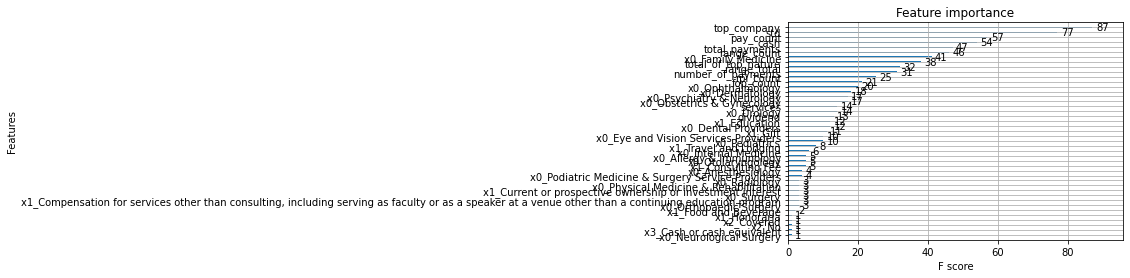

In [209]:
# feature importance plot
xgb.plot_importance(xgbc_opt)
plt.rcParams['figure.figsize'] = [12, 12]
plt.show()

# Logistic Regression Model

Logistic Regression is one of the most simple and commonly used Machine Learning algorithms for two-class classification. It is easy to implement and can be used as the baseline for any binary classification problem  
  
Estimation: Maximum Likelihood

In [210]:
# creating a logistic regression classifier object 
log_reg = LogisticRegression()

In [ ]:
# gridsearch to optimize the logistic regression model
LRparam_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100], # inverse of regularization strength
    'penalty': ['l1', 'l2'], # type of regularization penalty
    'max_iter': list(range(100,800,100)),
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

LR_gridsearch = GridSearchCV(log_reg, 
                             param_grid=LRparam_grid, 
                             refit = True, 
                             verbose = 2, 
                             cv=skfold, 
                             n_jobs=-1)

# fitting the model for grid search 
LR_gridsearch.fit(X_train , y_train)
LR_gridsearch.best_params_


Fitting 3 folds for each of 420 candidates, totalling 1260 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:   46.5s
[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 700 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1085 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1260 out of 1260 | elapsed:  6.5min finished


{'C': 10, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}

In [ ]:
# summarize
print('Mean Accuracy: %.3f' % LR_gridsearch.best_score_)
print('Config: %s' % LR_gridsearch.best_params_)

Mean Accuracy: 0.943
Config: {'C': 10, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}


Gridsearched Logistic Regression Model

In [ ]:
# optimal logistic regression model
# C: inverse of regularization strength, 
# solver: algorithm used for optimization problem, 
# penalty: norm used in the penalization term (l1 vs l2)
# max_iter: maximum no. of iterations for the solver to converge
log_reg_opt = LogisticRegression(C= 10, max_iter= 100, penalty= 'l1', solver='liblinear')

In [ ]:
# fitting the logistic regression model to the training data (LR model with gridsearch)
log_reg_opt.fit(X_train, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# predicting on the test set
y_pred_lr_opt = log_reg_opt.predict(X_test)

In [ ]:
# unique values (of a numpy array) of the predictions
np.unique(y_pred_lr_opt, return_counts=True)

(array([0, 1]), array([782,   6]))

Regular Logistic regression without Gridsearch

In [211]:
# fitting the logistic regression model to the training data (regular LR model without gridsearch)
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [214]:
# predicting on the test set
y_pred_lr = log_reg.predict(X_test)

In [213]:
# unique values (of a numpy array) of the predictions
np.unique(y_pred_lr, return_counts=True)

(array([0, 1]), array([979,  20]))

In [215]:
# unique values (of a numpy array) of the validation targets
np.unique(y_test, return_counts=True)

(array([0, 1]), array([942,  57]))

In [216]:
y_pred_lr.shape

(999,)

Model evaluation Gridsearched Log Reg

In [217]:
# computing the balanced accuracy score for the predictions (gridsearched Log Reg)
balanced_accuracy_score(y_test, y_pred_lr_opt)

NameError: ignored

In [ ]:
# evaluation the predicted classifications using a confusion matrix (gridsearched Log Reg)

conf_matrix = confusion_matrix(y_test, y_pred_lr_opt)

conf_matrix

array([[741,   4],
       [ 41,   2]])

Model evaluation regular Log Reg

In [ ]:
# computing an accuracy score for the predictions (evaluating predictions)
accuracy_score(y_test, y_pred_lr)

0.9365482233502538

In [218]:
# computing the balanced accuracy score for the predictions
balanced_accuracy_score(y_test, y_pred_lr)

0.5358978656833165

In [219]:
# evaluation the predicted classifications using a confusion matrix

conf_matrix = confusion_matrix(y_test, y_pred_lr)

conf_matrix

array([[927,  15],
       [ 52,   5]])

The Receiver Operating Characteristic(ROC) curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity

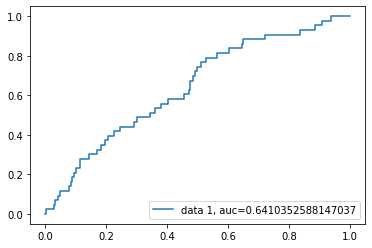

In [ ]:
# Plotting the Receiver Operator Curve (ROC)
y_pred_proba = log_reg.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# Naive Bayes

Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable

In [ ]:
# initializing a Gaussian Naive Bayes Classifier
gnb = GaussianNB()

In [ ]:
# fitting the model to the training data
gnb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
# obtaining predictions
y_pred_nb = gnb.predict(X_test)
print("Number of mislabeled points out of a total %d points : %d"
% (X_test.shape[0], (y_test != y_pred_nb).sum()))

Number of mislabeled points out of a total 788 points : 64


In [ ]:
# unique values (of a numpy array) of the predictions
np.unique(y_pred_nb, return_counts=True)

(array([0, 1]), array([759,  29]))

Model Evaluation

In [ ]:
# computing the balanced accuracy score for the predictions
balanced_accuracy_score(y_test, y_pred_nb)

0.5297331044170439

In [ ]:
# computing an accuracy score for the predictions (evaluating predictions)
accuracy_score(y_test, y_pred_nb)

0.9212198221092758

In [ ]:
# evaluation the predicted classifications using a confusion matrix

conf_matrix = confusion_matrix(y_test, y_pred_nb)

conf_matrix

array([[720,  25],
       [ 39,   4]])

# Final model with all Training data for Server submission

In [236]:
# we train a final model on 5000 data points
# labels 
y_train = train_final["Ownership_Indicator"]


# y_test is unknown

print(y_train)

0       0
1       0
2       0
3       0
4       0
       ..
4995    0
4996    0
4997    0
4998    0
4999    0
Name: Ownership_Indicator, Length: 5000, dtype: int64


In [237]:
# comparing column names of the final training data and the final test data
train_final.columns.isin(test_final.columns)

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True, False, False, False,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True, False,  True, False,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True])

In [238]:
# returning the columns only present in the training set but not in the test set
train_final.columns[~train_final.columns.isin(test_final.columns)]

Index(['Ownership_Indicator', 'x0_Chiropractic Providers',
       'x0_Medical Genetics', 'x0_Neuromusculoskeletal Medicine & OMM',
       'x0_Neuromusculoskeletal Medicine, Sports Medicine',
       'x0_Nuclear Medicine', 'x0_Oral & Maxillofacial Surgery',
       'x1_Charitable Contribution',
       'x1_Compensation for serving as faculty or as a speaker for an accredited or certified continuing education program',
       'x1_Current or prospective ownership or investment interest',
       'x2_Combination'],
      dtype='object')

In [247]:
all_features_test = test_final.columns[1:test_final.columns.shape[0]]

all_features_test = enc_features.drop("x0_Phlebology") # dropping the feature column not present in the training data

all_features_test

Index(['total_payments', 'number_of_payments', 'total_of_top_nature',
       'range_count', 'range_total', 'top_company', 'pay_count', 'std',
       'rpi_count', 'cash', 'services', 'stock', 'stock_opt', 'any_ownership',
       'dividend', 'stock_or_other', 'fop_count', 'x0_Allergy & Immunology',
       'x0_Anesthesiology', 'x0_Colon & Rectal Surgery', 'x0_Dental Providers',
       'x0_Dermatology', 'x0_Emergency Medicine',
       'x0_Eye and Vision Services Providers', 'x0_Family Medicine',
       'x0_General Practice', 'x0_Hospitalist', 'x0_Internal Medicine',
       'x0_Neurological Surgery', 'x0_Obstetrics & Gynecology',
       'x0_Ophthalmology', 'x0_Orthopaedic Surgery', 'x0_Otolaryngology',
       'x0_Pain Medicine', 'x0_Pathology', 'x0_Pediatrics',
       'x0_Physical Medicine & Rehabilitation', 'x0_Plastic Surgery',
       'x0_Podiatric Medicine & Surgery Service Providers',
       'x0_Preventive Medicine', 'x0_Psychiatry & Neurology', 'x0_Radiology',
       'x0_Surgery', 'x0_

In [248]:
# features (manually) 5000 data points
X_train = train_final.drop(['Ownership_Indicator', 'x0_Chiropractic Providers',
       'x0_Medical Genetics', 'x0_Neuromusculoskeletal Medicine & OMM',
       'x0_Neuromusculoskeletal Medicine, Sports Medicine',
       'x0_Nuclear Medicine', 'x0_Oral & Maxillofacial Surgery',
       'x1_Charitable Contribution',
       'x1_Compensation for serving as faculty or as a speaker for an accredited or certified continuing education program',
       'x1_Current or prospective ownership or investment interest',
       'x2_Combination'], axis=1)
#X_train = X_train[enc_features] # subsetting features

# 1000 data points for test set features
X_test = test_final[all_features_test]
print(X_train, X_test)

print(X_train.shape, X_test.shape)

      total_payments  ...  x3_In-kind items and services
0             952.93  ...                            1.0
1          120924.92  ...                            1.0
2            3523.93  ...                            1.0
3           26745.61  ...                            1.0
4           25411.21  ...                            1.0
...              ...  ...                            ...
4995         5528.35  ...                            1.0
4996        19714.41  ...                            1.0
4997         2946.90  ...                            1.0
4998         7870.54  ...                            1.0
4999         5779.80  ...                            0.0

[5000 rows x 62 columns]      total_payments  ...  x3_In-kind items and services
0           5775.53  ...                            1.0
1          92123.24  ...                            1.0
2           3159.49  ...                            1.0
3           1614.34  ...                            1.0
4         

In [245]:
X_train.columns

Index(['total_payments', 'number_of_payments', 'total_of_top_nature',
       'range_count', 'range_total', 'top_company', 'pay_count', 'std',
       'rpi_count', 'cash', 'services', 'stock', 'stock_opt', 'any_ownership',
       'dividend', 'stock_or_other', 'fop_count', 'x0_Allergy & Immunology',
       'x0_Anesthesiology', 'x0_Colon & Rectal Surgery', 'x0_Dental Providers',
       'x0_Dermatology', 'x0_Emergency Medicine',
       'x0_Eye and Vision Services Providers', 'x0_Family Medicine',
       'x0_General Practice', 'x0_Hospitalist', 'x0_Internal Medicine',
       'x0_Neurological Surgery', 'x0_Obstetrics & Gynecology',
       'x0_Ophthalmology', 'x0_Orthopaedic Surgery', 'x0_Otolaryngology',
       'x0_Pain Medicine', 'x0_Pathology', 'x0_Pediatrics',
       'x0_Physical Medicine & Rehabilitation', 'x0_Plastic Surgery',
       'x0_Podiatric Medicine & Surgery Service Providers',
       'x0_Preventive Medicine', 'x0_Psychiatry & Neurology', 'x0_Radiology',
       'x0_Surgery', 'x0_

In [246]:
X_test.columns

Index(['total_payments', 'number_of_payments', 'total_of_top_nature',
       'range_count', 'range_total', 'top_company', 'pay_count', 'std',
       'rpi_count', 'cash', 'services', 'stock', 'stock_opt', 'any_ownership',
       'dividend', 'stock_or_other', 'fop_count', 'x0_Allergy & Immunology',
       'x0_Anesthesiology', 'x0_Colon & Rectal Surgery', 'x0_Dental Providers',
       'x0_Dermatology', 'x0_Emergency Medicine',
       'x0_Eye and Vision Services Providers', 'x0_Family Medicine',
       'x0_General Practice', 'x0_Hospitalist', 'x0_Internal Medicine',
       'x0_Neurological Surgery', 'x0_Obstetrics & Gynecology',
       'x0_Ophthalmology', 'x0_Orthopaedic Surgery', 'x0_Otolaryngology',
       'x0_Pain Medicine', 'x0_Pathology', 'x0_Pediatrics', 'x0_Phlebology',
       'x0_Physical Medicine & Rehabilitation', 'x0_Plastic Surgery',
       'x0_Podiatric Medicine & Surgery Service Providers',
       'x0_Preventive Medicine', 'x0_Psychiatry & Neurology', 'x0_Radiology',
       '

Fitting an XGBClassifier model on 5000 data points

In [249]:
# count # of examples/data points in each class
counter = Counter(y_train)

counter


Counter({0: 4700, 1: 300})

In [250]:
# estimate scale_pos_weight value, assuming the class labels are 0 and 1
weight = counter[0] / counter[1]

weight


15.666666666666666

In [251]:
# initilizing the XGBClassifier as an object: (using all the default hyperparameters)
# here we initialize an XGBClassifier with a scale_pos_weight for imbalanced classification data
xgbc_final = xgb.XGBClassifier(scale_pos_weight= weight)



## Final Random Search & Model fit

In [252]:
# CV type 3: repeated stratified k-fold CV (due to imbalance in the data set) 
# maintains the ratio of instances in each class for each fold
# Repeated stratified k-fold CV involves simply repeating the cross-validation procedure multiple times 
# and reporting the mean result across all folds from all runs

n_folds=3 # no. of folds
n_repeats=3 # no. of runs

rskfold = RepeatedStratifiedKFold(n_splits=n_folds,n_repeats=n_repeats,
                                 random_state=123)

In [253]:
# estimator = xgbc is the xgb classifier model; "cv" determines the cross validation splitting strategy; "scoring" determines the loss function
clf_rscv_scores = cross_val_score(xgbc_final, X_train, y_train, cv=rskfold, scoring='balanced_accuracy')
print("Repeated Stratified K-fold CV average score: %.2f" % clf_rscv_scores.mean())

clf_rscv_scores # score per fold and run

Repeated Stratified K-fold CV average score: 0.71


array([0.71725271, 0.6892693 , 0.69678799, 0.70352585, 0.73331206,
       0.71273946, 0.74682195, 0.68607849, 0.73157088])

In [254]:
# define a search space for the RSCV
space = dict()
# Log-uniform is useful for searching penalty values as we often explore values at different orders of magnitude, at least as a first step.
space['reg_lambda'] = loguniform(1e-5, 100)
space['reg_alpha'] = loguniform(1e-5, 100) # loguniform distribution
space['max_depth'] = [3, 4, 5, 6, 7, 8, 9] # fixed set of values
space['min_child_weight'] = [1, 2, 3, 4]
space['colsample_by_tree'] = uniform(0.5, 0.4) # uniform distribution with lower bound 0.5 and range 0.4 so between 0.5 and 0.9
space['subsample'] = uniform(0.5, 0.4)
space['n_estimators'] = randint(150, 1000) # returns a pseudo random integer number from the given range 
space['learning_rate'] = uniform(0.01, 0.6)


In [255]:
# Randomized Search cross validation (scoring parameter is used to set the loss function for the gscv)
# n_iter: sets the number of iterations (the # of random combinations from the search space to try)

xgbc_rscv = RandomizedSearchCV(estimator = xgbc_final, 
                               n_iter= 20, 
                               scoring = 'balanced_accuracy', 
                               param_distributions = space, 
                               verbose=1, 
                               cv = rskfold, 
                               n_jobs=-1, 
                               random_state=123,
                               return_train_score = True)

In [256]:
# fitting the model multiple times to find the best hyperparameter combination
xgbc_rscv.fit(X_train, y_train)

Fitting 9 folds for each of 20 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 12.9min finished


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=3, random_state=123),
                   error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objecti...
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb5a194ceb8>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb5a194cd

In [257]:
# obtaining the best hyperparameter values from the Randomized Search CV
xgbc_rscv.best_params_

{'colsample_by_tree': 0.6577480215811099,
 'learning_rate': 0.44864382150673426,
 'max_depth': 5,
 'min_child_weight': 4,
 'n_estimators': 557,
 'reg_alpha': 81.72374423958811,
 'reg_lambda': 0.002791929884483455,
 'subsample': 0.8304820510130102}

In [258]:
# best score 
print(xgbc_rscv.scoring, xgbc_rscv.best_score_)

balanced_accuracy 0.7173286283028646


## Fitting the Optimal Model

{'colsample_by_tree': 0.7,
 'learning_rate': 0.01,
 'max_depth': 5,
 'min_child_weight': 1,
 'n_estimators': 250,
 'reg_alpha': 0.0,
 'reg_lambda': 0.8,
 'subsample': 0.7}

In [259]:
# setting up the optimal xgb classifier model using the configuration of hyperparameters from the GSCV or RSCV
xgbc_final_opt = xgb.XGBClassifier(objective="binary:logistic", obj="balanced_accuracy", feval = "balanced_accuracy", scale_pos_weight = weight, booster="gbtree",learning_rate=0.44864382150673426, colsample_bytree=0.6577480215811099, max_depth=5, min_child_weight=4,n_estimators = 557, subsample = 0.8304820510130102, reg_alpha =81.72374423958811, reg_lambda=0.002791929884483455)

In [260]:
# fitting the XGB classifier model to the training data (final model with optimal hyperparameters from the gscv)
xgbc_final_opt.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6577480215811099,
              feval='balanced_accuracy', gamma=0,
              learning_rate=0.44864382150673426, max_delta_step=0, max_depth=5,
              min_child_weight=4, missing=None, n_estimators=557, n_jobs=1,
              nthread=None, obj='balanced_accuracy',
              objective='binary:logistic', random_state=0,
              reg_alpha=81.72374423958811, reg_lambda=0.002791929884483455,
              scale_pos_weight=15.666666666666666, seed=None, silent=None,
              subsample=0.8304820510130102, verbosity=1)

In [261]:
# making predictions using the test data
y_pred_xgbc_final = xgbc_final_opt.predict(X_test)


In [262]:
# unique values (of a numpy array) of the predictions
np.unique(y_pred_xgbc_final, return_counts=True)


(array([0, 1]), array([835, 165]))

# Exporting the predicitions for a submission

Export predictions into csv file  
• Format: id, prediction  
• Predictions must be 0 or 1 (not 0.5, not ‘Yes’, not ‘FALSE’)  
• Must contain all instances of the original test dataset

In [263]:
test_final.columns

Index(['Physician_ID', 'total_payments', 'number_of_payments',
       'total_of_top_nature', 'range_count', 'range_total', 'top_company',
       'pay_count', 'std', 'rpi_count', 'cash', 'services', 'stock',
       'stock_opt', 'any_ownership', 'dividend', 'stock_or_other', 'fop_count',
       'x0_Allergy & Immunology', 'x0_Anesthesiology',
       'x0_Colon & Rectal Surgery', 'x0_Dental Providers', 'x0_Dermatology',
       'x0_Emergency Medicine', 'x0_Eye and Vision Services Providers',
       'x0_Family Medicine', 'x0_General Practice', 'x0_Hospitalist',
       'x0_Internal Medicine', 'x0_Neurological Surgery',
       'x0_Obstetrics & Gynecology', 'x0_Ophthalmology',
       'x0_Orthopaedic Surgery', 'x0_Otolaryngology', 'x0_Pain Medicine',
       'x0_Pathology', 'x0_Pediatrics', 'x0_Phlebology',
       'x0_Physical Medicine & Rehabilitation', 'x0_Plastic Surgery',
       'x0_Podiatric Medicine & Surgery Service Providers',
       'x0_Preventive Medicine', 'x0_Psychiatry & Neurology', '

In [264]:
final_preds = y_pred_xgbc_final

In [265]:
# storing the ids and the corresponding predictions as a combined dataframe

submission = pd.DataFrame()

submission["id"] = test_final["Physician_ID"]

submission["prediction"] = final_preds


submission



,id,prediction
0,14,0
1,18,0
2,42,0
3,46,0
4,47,0
...,...,...
995,5953,0
996,5959,0
997,5964,0
998,5972,1


In [266]:
# storing the submission data in a csv file
submission.to_csv('submission_team_sgs_4.csv', index=False) 

In [267]:
from google.colab import files
files.download("submission_team_sgs_4.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>